In [1]:
import torch
import numpy as np
import scipy.integrate
from numpy import sin, cos
import matplotlib.pyplot as plt
import random
solver = scipy.integrate.solve_ivp

seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.determinstic = True

In [2]:
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
import pandas as pd

BATCH_size = 1000

dftarget = pd.read_csv("./data/target.csv", header=None, dtype=np.float32)
dfinput = pd.read_csv("./data/input.csv", header=None, dtype=np.float32)

X_train, X_test, Y_train, Y_test = train_test_split(dfinput.values, dftarget.values, test_size=0.2)

# train data
data_train = data_utils.TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_size, shuffle=True)

# test data
data_test = data_utils.TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))
test_loader = torch.utils.data.DataLoader(data_test, batch_size=BATCH_size, shuffle=True)

In [3]:
import torch.nn as nn
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#!nvidia-smi

In [4]:
class MLP(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(MLP,self).__init__()
    self.l1 = nn.Linear(input_size,hidden_size)
    self.l2 = nn.Linear(hidden_size,hidden_size)
    self.l3 = nn.Linear(hidden_size,output_size)
  
  def forward(self,x):
    x = self.l1(x)
    x = torch.tanh(x)
    x = self.l2(x)
    x = torch.tanh(x)
    x = self.l3(x)
    return x

  def grad(self,x):
    x = x.requires_grad_(True)
    with torch.enable_grad():
      hamiltonian = self(x)
      gradient = torch.autograd.grad(hamiltonian.sum(),x,create_graph=True,retain_graph=True)
    return gradient[0]

  def fvec(self,t,x):
    return self.grad(x)

In [5]:
class MLPS(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLPS, self).__init__()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.l2 = nn.Linear(hidden_size, hidden_size)
    self.l3 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = self.l1(x)
    x = torch.tanh(x)
    x = self.l2(x)
    x = torch.tanh(x)
    x = self.l3(x)
    return x

In [6]:
import time
input_size = 4
hidden_size = 200
output_size = 1

input_size_s = 4
hidden_size_s = 200
output_size_s = 6

num_trials = 10
stats = {'train_loss': [], 'eval_loss': [], 'computation_time': []}

for trial in range(num_trials):
  h_nn = MLP(input_size, hidden_size, output_size).to(device)
  s_nn = MLPS(input_size_s, hidden_size_s, output_size_s).to(device)
  num_epochs = 2000
  criterion = nn.MSELoss()
  parmas = list(h_nn.parameters()) + list(s_nn.parameters())
  optimizer = optim.Adam(params=parmas,lr=0.001)

  history_loss = []
  history_eval = []
  history_acc = []
  startt = time.time()
  for epoch in range(num_epochs):
    estartt = time.time()
    h_nn.train()
    s_nn.train()

    total_loss = 0.0
    eval_loss = 0.0
    cnt = 0
    for i,(data,target) in enumerate(train_loader):
      optimizer.zero_grad()
      x = data.to(device)
      output = h_nn.grad(x)
      skew_init = s_nn.forward(x)
      skew_n = torch.zeros(skew_init.shape[0],4,4).to(device)
      skew_n[:,0,1] = skew_init[:,0]
      skew_n[:,0,2] = skew_init[:,1]
      skew_n[:,0,3] = skew_init[:,2]
      skew_n[:,1,2] = skew_init[:,3]
      skew_n[:,1,3] = skew_init[:,4]
      skew_n[:,2,3] = skew_init[:,5]
      skew_n[:,1,0] = -skew_init[:,0]
      skew_n[:,2,0] = -skew_init[:,1]
      skew_n[:,3,0] = -skew_init[:,2]
      skew_n[:,2,1] = -skew_init[:,3]
      skew_n[:,3,1] = -skew_init[:,4]
      skew_n[:,3,2] = -skew_init[:,5]
      
      output = output.unsqueeze(2)
      output = torch.matmul(skew_n, output)
      output = output.squeeze(2)

      target = target.to(device)

      loss = criterion(output,target)
      loss.backward()
      optimizer.step()
     

      total_loss = total_loss+loss.cpu().item()
      cnt = cnt + 1
    total_loss = total_loss/cnt
  
    num_correct = 0
    num_data = 0
    h_nn.eval()
    s_nn.eval()
    eval_loss = 0.0
    cnt = 0
    for i,(data,target) in enumerate(test_loader):
      optimizer.zero_grad()
      x = data.to(device)
      output = h_nn.grad(x)
      skew_init = s_nn.forward(x)
      skew_n = torch.zeros(skew_init.shape[0],4,4).to(device)
      skew_n[:,0,1] = skew_init[:,0]
      skew_n[:,0,2] = skew_init[:,1]
      skew_n[:,0,3] = skew_init[:,2]
      skew_n[:,1,2] = skew_init[:,3]
      skew_n[:,1,3] = skew_init[:,4]
      skew_n[:,2,3] = skew_init[:,5]
      skew_n[:,1,0] = -skew_init[:,0]
      skew_n[:,2,0] = -skew_init[:,1]
      skew_n[:,3,0] = -skew_init[:,2]
      skew_n[:,2,1] = -skew_init[:,3]
      skew_n[:,3,1] = -skew_init[:,4]
      skew_n[:,3,2] = -skew_init[:,5]
      
      output = output.unsqueeze(2)
      output = torch.matmul(skew_n, output)
      output = output.squeeze(2)

      eval_loss = eval_loss+criterion(output,target.to(device)).cpu().item()
      cnt = cnt + 1
    eval_loss = eval_loss/cnt

    history_loss.append(total_loss)
    history_eval.append(eval_loss)
  print("{}/{} training loss:{},evaluation loss:{}".format(epoch+1,num_epochs,total_loss,eval_loss))
  path = "./model/skew_h_ms_v1{}".format(trial)
  torch.save(h_nn.state_dict(), path)
  path = "./model/skew_s_ms_v1{}".format(trial)
  torch.save(s_nn.state_dict(), path)
  stats['train_loss'].append(total_loss)
  stats['eval_loss'].append(eval_loss)
  stats['computation_time'].append(time.time() - startt)

print("train_loss:{}, std: {}".format(np.mean(stats['train_loss']), np.std(stats['train_loss'])))
print("test_loss:{}, std: {}".format(np.mean(stats['eval_loss']), np.std(stats['eval_loss'])))
print("computation_time:{}, std: {}".format(np.mean(stats['computation_time']), np.std(stats['computation_time'])))

2000/2000 training loss:0.0002580302249043598,evaluation loss:0.00024642537100589835
2000/2000 training loss:2.438706493421705e-05,evaluation loss:2.1969629233353772e-05
2000/2000 training loss:0.00025679158479761097,evaluation loss:0.0002552231286244933
2000/2000 training loss:3.0087998993622023e-05,evaluation loss:3.128758262391784e-05
2000/2000 training loss:3.0149256588174467e-05,evaluation loss:3.19863711411017e-05
2000/2000 training loss:2.7769335565608345e-05,evaluation loss:2.1912910597166047e-05
2000/2000 training loss:0.0004857687890762463,evaluation loss:0.0006007674935972318
2000/2000 training loss:2.4781655747574403e-05,evaluation loss:2.4247247438324848e-05
2000/2000 training loss:2.2755662439521984e-05,evaluation loss:2.7263234096608356e-05
2000/2000 training loss:3.9980360156732786e-05,evaluation loss:3.96599093619443e-05
train_loss:0.00012005019332036683, std: 0.00015175073389876143
test_loss:0.00013007428777200405, std: 0.00017985040706278168
computation_time:1104.487

In [9]:
A = pd.read_csv("./data/A.csv", header=None, dtype=np.float32)
B = pd.read_csv("./data/B.csv", header=None, dtype=np.float32)
#A = np.mat(A) # `np.mat` was removed in the NumPy 2.0 release. Use `np.asmatrix` instead.
#B = np.mat(B)
A = np.asmatrix(A)
B = np.asmatrix(B)

[0.33934223 0.36219116 0.44109076 0.66546418]


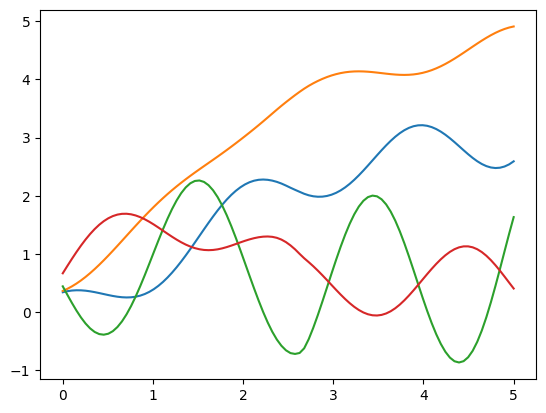

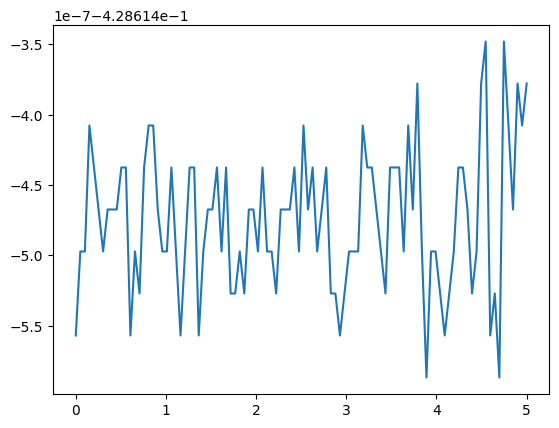

energy_error0:1.7881393432617188e-07
energy_error0:6.275175776775881


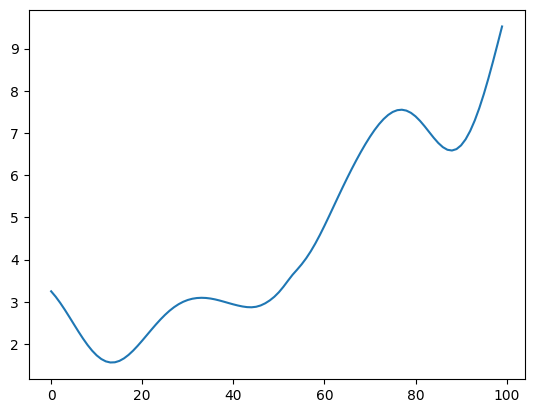

[0.70399322 0.90125315 0.02954776 0.49957685]


/tmp/ipykernel_41428/2430343672.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A, dtype=torch.float32)
/tmp/ipykernel_41428/2430343672.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  B = torch.tensor(B, dtype=torch.float32)


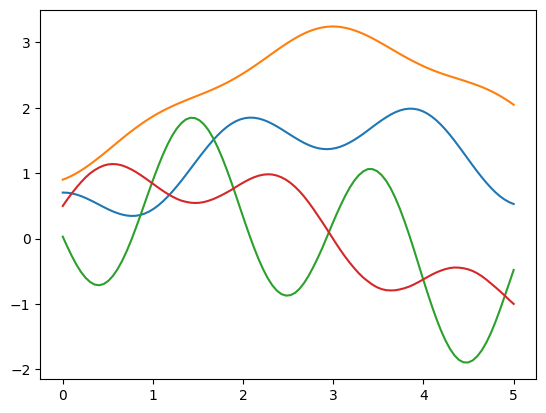

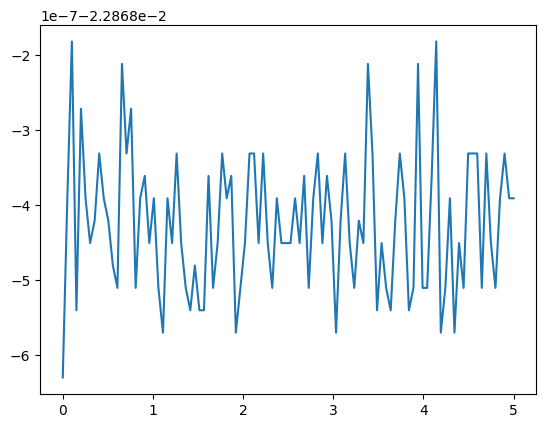

energy_error1:2.384185791015625e-07
energy_error1:-0.4347445600265709


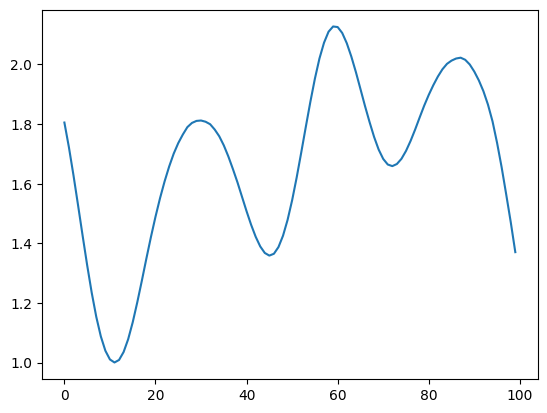

[0.44740635 0.49796745 0.72791378 0.12088727]


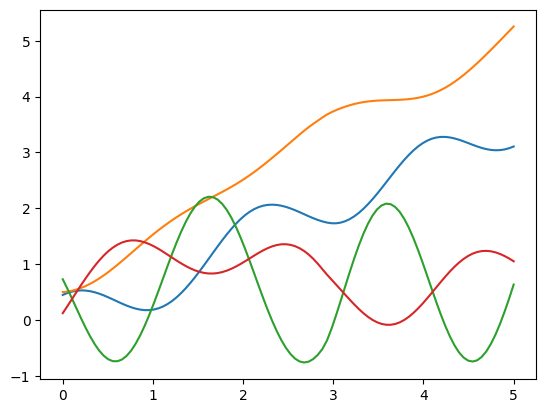

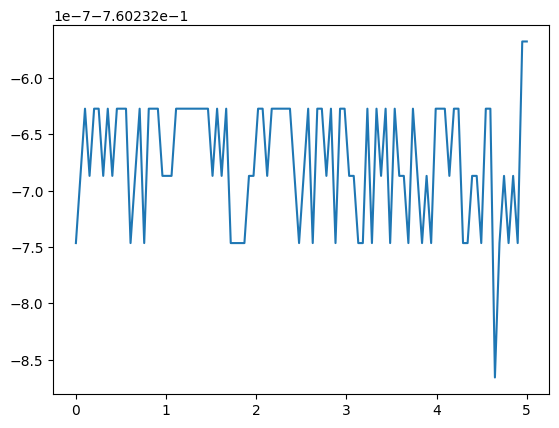

energy_error2:1.7881393432617188e-07
energy_error2:7.449696304096557


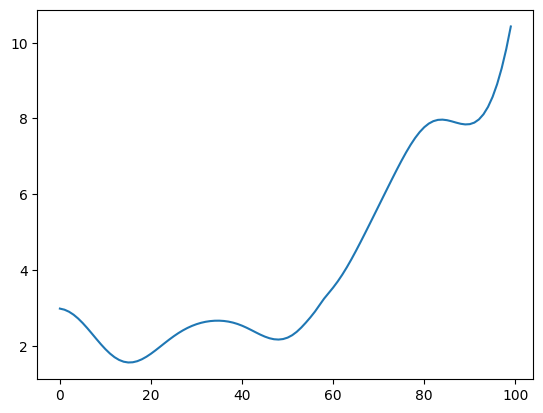

[0.92729446 0.15537564 0.67088593 0.02294421]


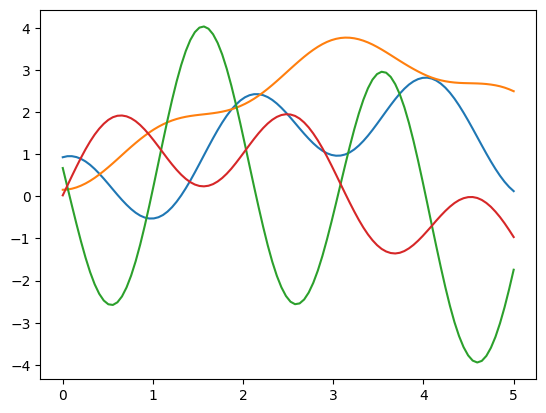

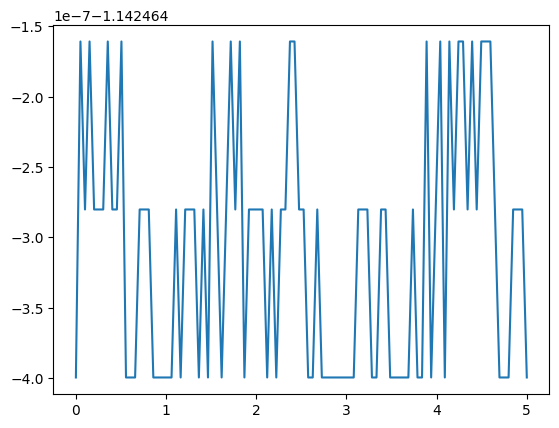

energy_error3:0.0
energy_error3:-0.4699274416678172


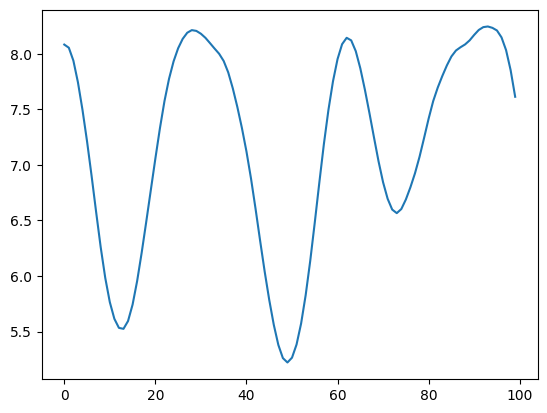

[0.26289127 0.56600179 0.43882605 0.79554568]


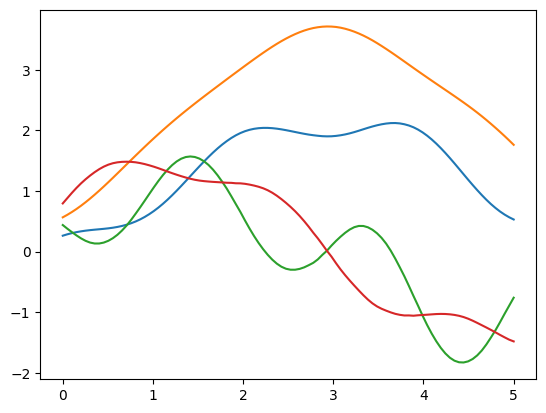

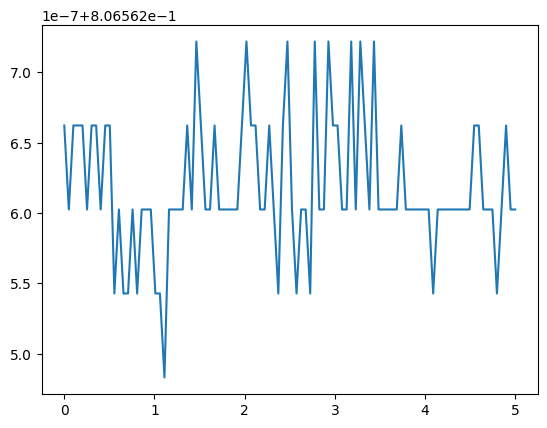

energy_error4:-5.960464477539063e-08
energy_error4:-0.9784973037832418


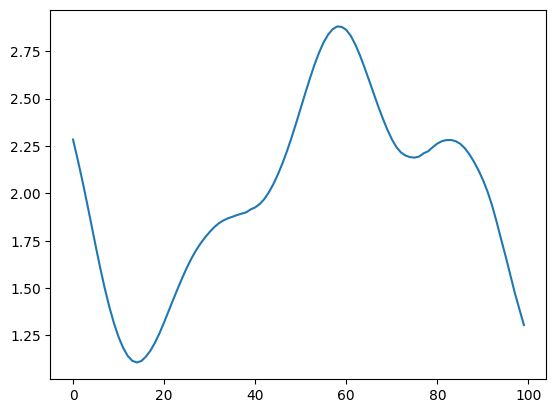

[0.04651726 0.15780542 0.63263753 0.5602046 ]


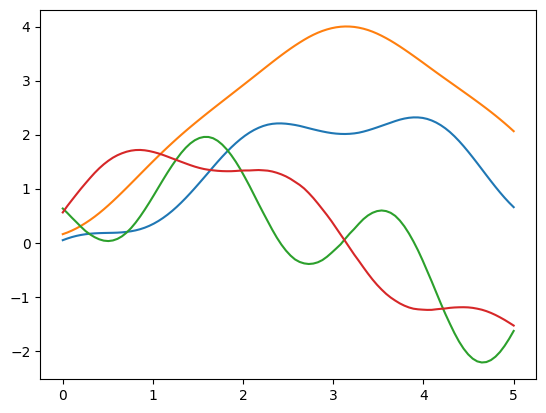

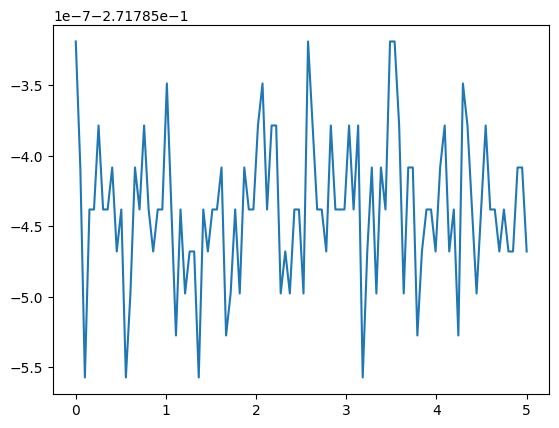

energy_error5:-1.4901161193847656e-07
energy_error5:-1.1070358538956917


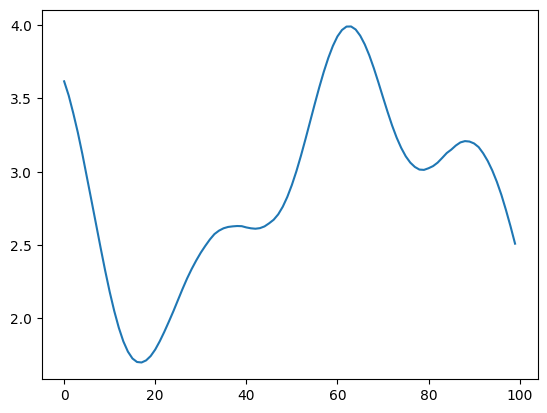

[0.21905157 0.51230553 0.8936477  0.5353286 ]


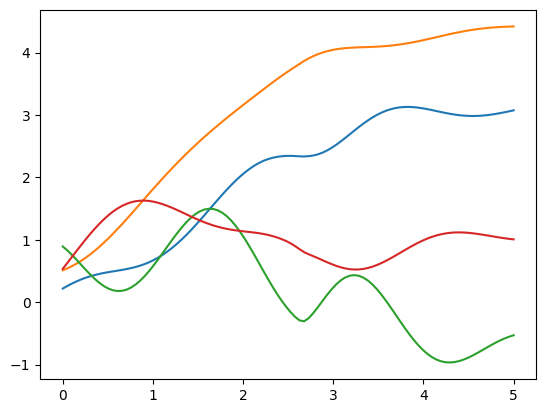

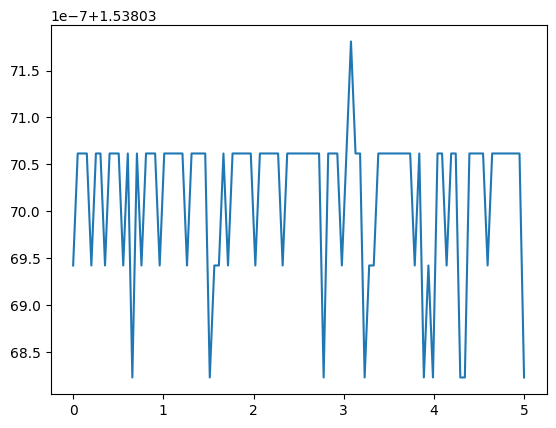

energy_error6:-1.1920928955078125e-07
energy_error6:4.515359929759865


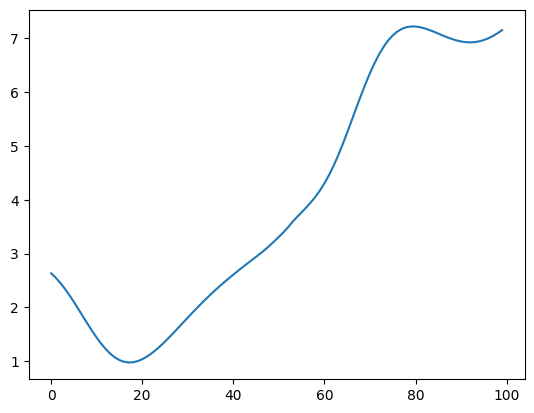

[0.36413251 0.70455736 0.42702708 0.50627118]


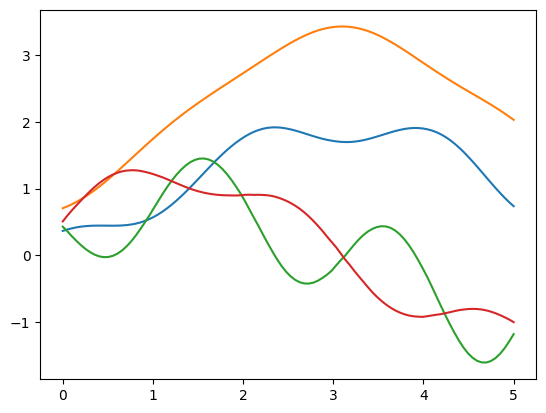

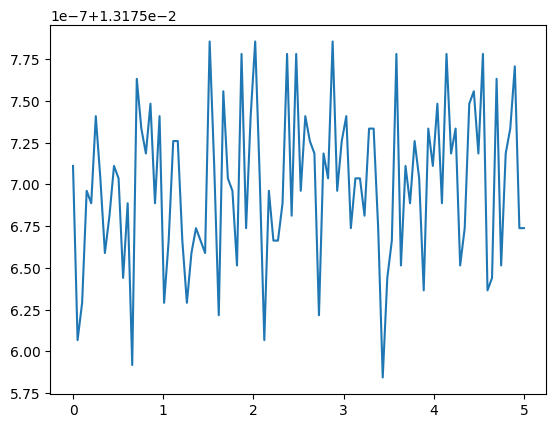

energy_error7:-3.725290298461914e-08
energy_error7:-0.5676208661258091


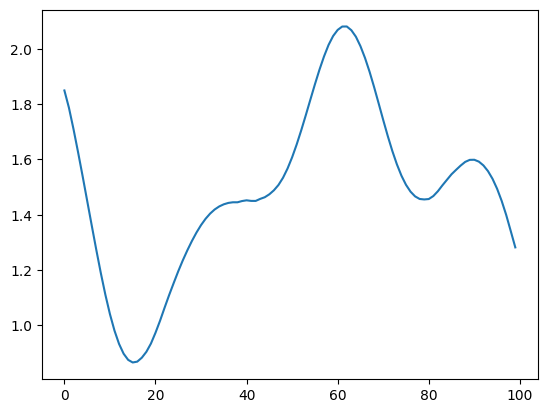

[0.67855903 0.87849157 0.03212936 0.18337338]


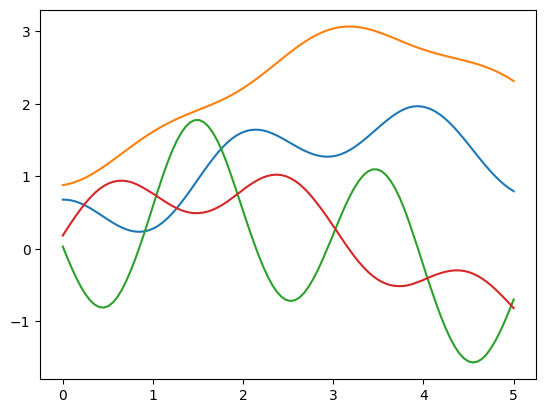

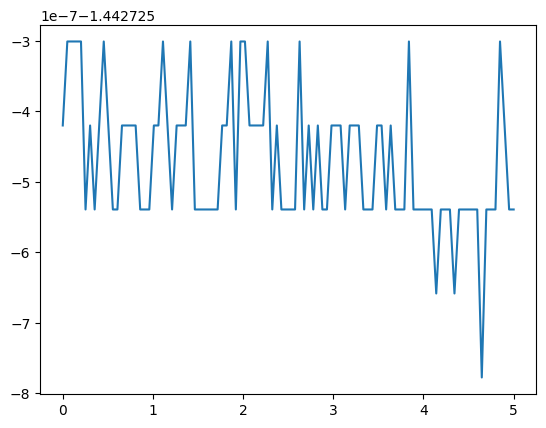

energy_error8:-1.1920928955078125e-07
energy_error8:-0.6183065887600543


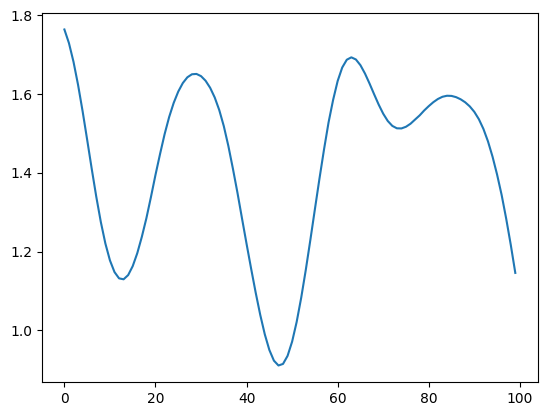

[0.61195673 0.75961104 0.57334028 0.91612824]


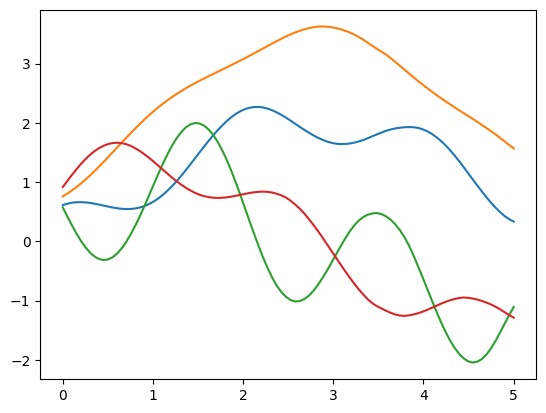

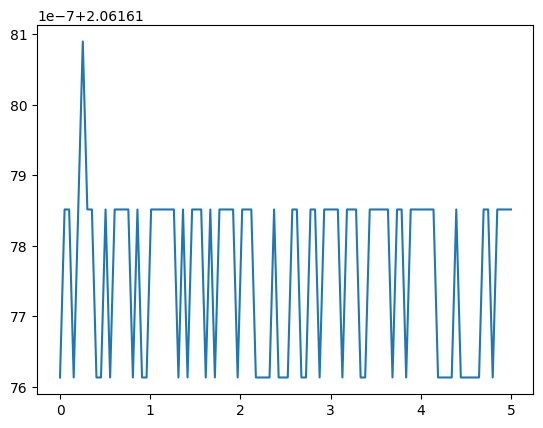

energy_error9:2.384185791015625e-07
energy_error9:-0.582969642775407


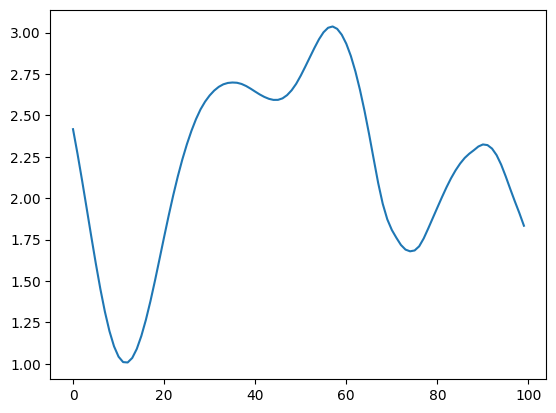

eq_error:[np.float64(6.275175776775881), np.float64(-0.4347445600265709), np.float64(7.449696304096557), np.float64(-0.4699274416678172), np.float64(-0.9784973037832418), np.float64(-1.1070358538956917), np.float64(4.515359929759865), np.float64(-0.5676208661258091), np.float64(-0.6183065887600543), np.float64(-0.582969642775407)] net_error:[np.float32(1.7881393e-07), np.float32(2.3841858e-07), np.float32(1.7881393e-07), np.float32(0.0), np.float32(-5.9604645e-08), np.float32(-1.4901161e-07), np.float32(-1.1920929e-07), np.float32(-3.7252903e-08), np.float32(-1.1920929e-07), np.float32(2.3841858e-07)]
eq_error:2.2999334267666898, std: 3.1737574810095674
net_error:1.3187528224989364e-07, std: 1.4864048125673435e-07


In [10]:
# simulation
# parameters
k1 = 3.0
k2 = 5.0
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
eq_error = []
net_error = []
for trial in range(num_trials):
  s_nn.load_state_dict(torch.load("./model/skew_s_ms_v1{}".format(trial), map_location=device))
  s_nn.eval()
  h_nn.load_state_dict(torch.load("./model/skew_h_ms_v1{}".format(trial), map_location=device))
  h_nn.eval()
  teval = torch.linspace(0.0,5.0,100)
  #x0 = np.random.uniform(low=0.0, high=1.0, size=2)
  x0 = np.random.rand(4)
  #x0 = (0.91369884, 0.76173912, 0.7811432,  0.44947022)
  print(x0)
  dt = teval[1]-teval[0]

  
  teval = teval.detach().cpu().numpy()
  A = torch.tensor(A, dtype=torch.float32)
  B = torch.tensor(B, dtype=torch.float32)
  h_nn.cpu()
  s_nn.cpu()
  def fvec_np(x, t):
      tx = torch.tensor(x, dtype=torch.float).unsqueeze(0)
      x = torch.matmul(tx, torch.inverse(B))
      output = h_nn.grad(x)
      skew_init = s_nn.forward(x)
      skew_n = torch.zeros(skew_init.shape[0],4,4)
      skew_n[:,0,1] = skew_init[:,0]
      skew_n[:,0,2] = skew_init[:,1]
      skew_n[:,0,3] = skew_init[:,2]
      skew_n[:,1,2] = skew_init[:,3]
      skew_n[:,1,3] = skew_init[:,4]
      skew_n[:,2,3] = skew_init[:,5]
      skew_n[:,1,0] = -skew_init[:,0]
      skew_n[:,2,0] = -skew_init[:,1]
      skew_n[:,3,0] = -skew_init[:,2]
      skew_n[:,2,1] = -skew_init[:,3]
      skew_n[:,3,1] = -skew_init[:,4]
      skew_n[:,3,2] = -skew_init[:,5]

      output = output.unsqueeze(2)
      output = torch.matmul(skew_n, output)
      output = torch.matmul(A, output)
      output = output.squeeze(2)
      #print(output)
      output = output.squeeze(0)
      return output.detach().cpu().numpy()
  res = scipy.integrate.odeint(fvec_np, x0, teval)

  plt.plot(teval,res[:,0])
  plt.plot(teval,res[:,1])
  plt.plot(teval,res[:,2])
  plt.plot(teval,res[:,3])
  plt.show()
  def net_energy(x,t):
    tx = torch.tensor(x, dtype=torch.float)
    x = torch.matmul(tx, torch.inverse(B))
    ne = h_nn(x).squeeze(0)
    return ne.detach().cpu().numpy()

  net_energy = net_energy(res, teval).reshape((100))
  plt.plot(teval,net_energy)
  plt.show()
  net_energy_error=net_energy[99]-net_energy[0]
  print("energy_error{}:{}".format(trial,net_energy_error))
    
  energy = np.square(res[:,2])/(2*m1) + np.square(res[:,3])/(2*m2) + k1*np.square((res[:,0]-l1))/2 + k2*np.square((res[:,1]-res[:,0]-l2))/2
  energy_error=energy[99]-energy[0]
  print("energy_error{}:{}".format(trial,energy_error))
  plt.plot(energy)
  plt.show()

  eq_error.append(energy_error)
  net_error.append(net_energy_error)
print("eq_error:{}".format(eq_error),"net_error:{}".format(net_error))
print("eq_error:{}, std: {}".format(np.mean(np.abs(eq_error)), np.std(eq_error)))
print("net_error:{}, std: {}".format(np.mean(np.abs(net_error)), np.std(net_error)))

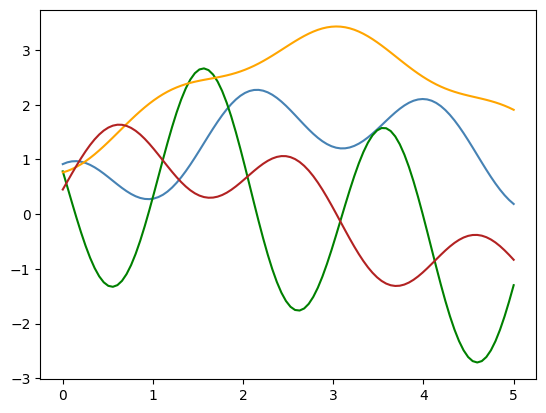

In [11]:
# Ground truth
# parameters
k1 = 3.0
k2 = 5.0
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
# equations of motion
def func(t, state):
  dvdt = np.zeros_like(state)
  dvdt[0] = state[2]
  dvdt[1] = state[3]
  dvdt[2] = (-k1*(state[0]-l1)+k2*(state[1]-state[0]-l2))/m1
  dvdt[3] = -k2*(state[1]-state[0]-l2)/m2
  return dvdt

M = 100
tend = 5.0
t_eval = np.linspace(0,tend,M)
dt = t_eval[1]-t_eval[0]

x1_init = np.random.randn(1)
x2_init = np.random.randn(1)
#print(x1)
v1_init = np.random.randn(1)
v2_init = np.random.randn(1)
state = []
for i in range(1):
  s = (0.91369884, 0.76173912, 0.7811432,  0.44947022)
  state.append(s)
p1 = []
v1 = []
p2 = []
v2 = []
flag = False
for i in range(1):
  sol = solver(func, [0, tend], state[i], t_eval=t_eval)
  tval = sol['t']
  dv1dt = sol['y'][0], sol['y'][1]
  dv2dt = sol['y'][2], sol['y'][3]
  p1 = dv1dt[0]
  p2 = dv1dt[1]
  v1 = dv2dt[0]
  v2 = dv2dt[1]
  plt.plot(tval, p1, 'steelblue')
  plt.plot(tval, v1, 'g')
  plt.plot(tval, p2, 'orange')
  plt.plot(tval, v2, 'firebrick')
  plt.show()
